In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

Configuration section

In [19]:
# Environment type (local|colab)
env = 'colab'

# Run on Google Colab
if (env == 'colab'):
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Terminal commands to copy and unzip dateset to a local storage
    #cp -r /content/drive/MyDrive/ColabNotebooks/FaceUpscale/data.zip /content
    #7z x data.zip

    # Locations and batch size
    train_folder = '/content/train'
    test_folder = '/content/test'
    train_batch_size = 64

# Run Local
if (env == 'local'):
    # Locations and batch size
    train_folder = '../data/train'
    test_folder = '../data/test'
    cache_folder = '../data/cache'
    train_batch_size = 4

# input image size
x_img_size = 32

# output image size
y_img_size = 128
# output image channels
y_img_channels = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data access section

Contains methods for accessing and enumerating image datasets

In [20]:
# Cached image file pathes to avoid scan Filesystem on every epoch and to shuffle images
train_files_list = []
test_files_list = []

# Recursively enumerates image files starting from given root folder
def image_file_iterator(root):
    for subdir, dirs, files in os.walk(root):        
        for file in files:
            if (file.endswith('.png')):
                yield os.path.join(subdir, file)

        for dir in dirs:
            for file in image_file_iterator(dir):
                yield os.path.join(subdir, file)

# Shuffles and enumerates Train file pathes 
def train_files_shuffled_iterator():
    global train_files_list
    if (len(train_files_list) == 0):
        train_files_list = list(image_file_iterator(train_folder))

    np.random.shuffle(train_files_list)

    for f in train_files_list:
        yield f

# Enumerates Test file pathes
def test_files_iterator():
    global test_files_list
    if (len(test_files_list) == 0):
        test_files_list = list(image_file_iterator(test_folder))

    for f in test_files_list:
        yield f


Image processing section

Contains methods for image processing and augmentation 

In [21]:

# Scale image and normalize pixels to float 0..1 range
def scale_and_normalize(img, size):
    if (img.shape[0] != size or img.shape[1] != size):
        img = cv2.resize(img, (size, size))
    return img / 255

# Rotates image for given degrees angle
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LANCZOS4)
  return result

# Horizontal flip
def flip_image(img):
    return cv2.flip(img, 1)

# Loading images using given File path iterator, iterates image batches as a result
# Note: When augmentation is enabled then every returning batch contains 4 times more images then requested via batch_size
def data_iterator(file_iterator, batch_size, augmentation = False):
    global file_cache_enabled
    files_pending = True
    while(files_pending):
        # resulting batches
        x_batch = []
        y_batch = []

        for _ in range(batch_size):
            # get next file path
            fpath = next(file_iterator, None) 

            # If file iterator provided a file path
            if (fpath is not None):
                # Load source image
                src_img = cv2.imread(fpath)
                src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

                # Make normal XY
                x_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
                x_img = scale_and_normalize(x_img, x_img_size)
                y_img = scale_and_normalize(src_img, y_img_size)
                x_batch.append(x_img)
                y_batch.append(y_img)
                    
                if (not augmentation):
                    continue

                # Flipped XY
                x_img = flip_image(x_img)
                y_img = flip_image(y_img)
                x_batch.append(x_img)
                y_batch.append(y_img)

                # Rotated XY
                angle = np.random.randint(10,20)                    
                y_img = rotate_image(src_img, angle)
                x_img = cv2.cvtColor(y_img, cv2.COLOR_RGB2GRAY)
                x_img = scale_and_normalize(x_img, x_img_size)
                y_img = scale_and_normalize(y_img, y_img_size)
                x_batch.append(x_img)
                y_batch.append(y_img)

                # Rotated flipped XY
                x_img = flip_image(x_img)
                y_img = flip_image(y_img)
                x_batch.append(x_img)
                y_batch.append(y_img)

            # If file's iterator end reached
            else:
                files_pending = False
                break
        
        if len(x_batch) > 0:
            yield np.array(x_batch), np.array(y_batch)

Tests for data iterators

In [22]:
# Let's test file iterators and see the number of files
train_set_len = sum(1 for _ in image_file_iterator(train_folder))
test_set_len = sum(1 for _ in image_file_iterator(test_folder))

print('Train files:', train_set_len)
print('Test files:', test_set_len)

# Also do a smoke test for datagen 
# for 1000 test images we expecting 1000 batches (when batch_size = 1)
if (sum(1 for _ in data_iterator(test_files_iterator(), batch_size=1)) == test_set_len):
    print('data_iterator OK')
else:
    print('data_iterator failure!')

# for 1000 test images we expecting 500 batches (when batch_size = 2)
if (sum(1 for _ in data_iterator(test_files_iterator(), 2)) == test_set_len / 2):
    print('data_iterator OK')
else:
    print('data_iterator failure!')


Train files: 65284
Test files: 1000
data_iterator OK
data_iterator OK


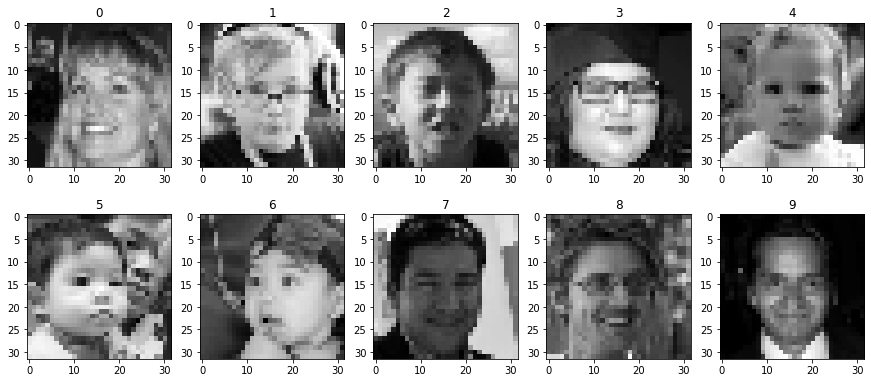

In [23]:
# test data_iterator for Train set (without augmentation)
# get a single batch of 10 images
batch = next(data_iterator(train_files_shuffled_iterator(), 10))

x_train_batch = batch[0]
y_train_batch = batch[1]

# Show X
for ii in range(x_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(x_train_batch[ii], cmap = 'gray'), plt.title(ii)

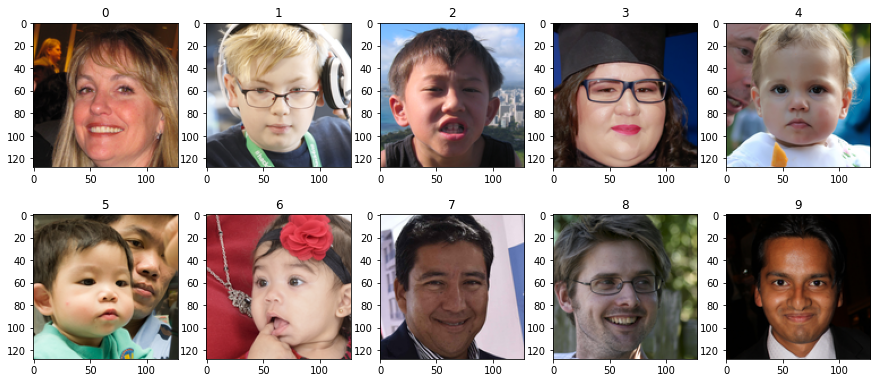

In [24]:
# Show Y
for ii in range(y_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(y_train_batch[ii]), plt.title(ii)

Deep learning section

I'm using Residual Dense Blocks + Pixel Shuffle Super Resolution network model with custom loss function and PSNR metric

The overal network structure is:
[INPUT]-[CONV]-[CONV]-[RDB]-[CONV]-[RDB]-[CONV]-[PIXEL-SHUFFLE]-[OUTPUT]

where [RDB] is a Residual Dense Blocks part consisting of a number of interconnected [CONV] layers
and [PIXEL-SHUFFLE] is a special layer that converts a number of input layers to a WxH layer  

In [25]:
# Residual Dense Blocks function
def rdb_block(inputs, layers_count):
    # get number of input channels
    channels = inputs.get_shape()[-1]
    # initialize outputs list
    outputs = [inputs]
    
    # common Conv2D args
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

    # Make Residual Dense Block
    for _ in range(layers_count):
        concatenation = tf.concat(outputs, axis=-1)
        net = Conv2D(channels, 3, **conv_args)(concatenation)
        outputs.append(net)

    # Make final resulting net
    final_concatenation = tf.concat(outputs, axis=-1)
    final_net = Conv2D(channels, 1, **conv_args)(final_concatenation)

    # Add input net and final output net (RDB)
    final_net = Add()([final_net, inputs])

    return final_net

In [26]:
if (env == 'local'):
    # workaround for some unclear error
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Common args we will use for all Conv2D layers 
conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

# We need to know Y to X scale to initialize a pixel-shuffle layer properly
scale_ratio = int(y_img_size / x_img_size)
print('Scale ratio: ', scale_ratio)

inputs = Input(shape=(x_img_size, x_img_size, 1))
net = Conv2D(80, 5, **conv_args)(inputs)
net = Conv2D(80, 3, **conv_args)(net)
# Adding RDB Block
net = rdb_block(net, layers_count=8)
net = Conv2D(48, 3, **conv_args)(net)
# Adding other RDB Block
net = rdb_block(net, layers_count=8)
net = Conv2D(48, 3, **conv_args)(net)
# Pixel-shuffling
net = Conv2D(y_img_channels * (scale_ratio ** 2), 3, **conv_args)(net)
# Output
outputs = tf.nn.depth_to_space(net, scale_ratio)

model = Model(inputs, outputs)
model.summary()

Scale ratio:  4
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 80)   2080        ['input_2[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 80)   57680       ['conv2d_23[0][0]']              
                                                                                                  
 tf.identity_2 (TFOpLambda)     (None, 32, 32, 80)   0           ['conv2d_24[0][0]']              
                                                                            

Train infrastructure section

In [27]:
# Peak Signal to Noise Ratio function
def psnr(orig, pred):
    # cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [28]:
# Wrapper for the data_iterator from Data Access section 
# makes data_iterator infinite
def datagen(batch_size):
    iterator = data_iterator(train_files_shuffled_iterator(), batch_size, augmentation=True)
    while(True):
        result = next(iterator, None)

        if (result is None):
            iterator = data_iterator(train_files_shuffled_iterator(), batch_size)
        else:
            yield result
            

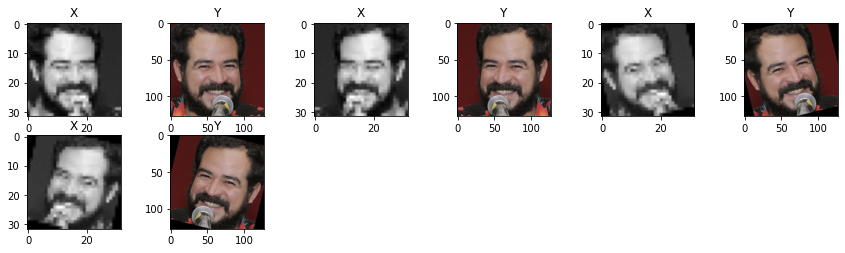

In [29]:
# Test the train datagen: get a single batch with batch_size=1 to check augmentation
def do_test_datagen():
    # Create datagenerator
    dg = datagen(1)
    img_n = 0

    # get a batch
    x_batch, y_batch = next(dg)

    # Show all the images returned in a batch: there must be one original XY pair and three augmentation versions 
    for ii in range(x_batch.shape[0]):
        img_n += 1
        plt.subplot(5,6,img_n), plt.imshow(x_batch[ii], cmap = 'gray'), plt.title('X')
        img_n += 1
        plt.subplot(5,6,img_n), plt.imshow(y_batch[ii], cmap = 'gray'), plt.title('Y')
           
do_test_datagen()

In [30]:
# Loss function class
# The idea is to calculate MSE differently for image center part and image side parts
# because 99% of the train set has face in a entral part of image
# and we want our network to not to confuse by image background while training    
class CenterImagePriorityLoss(tf.keras.losses.Loss):

  # Defines the multiplication of a center MSE over a total MSE 
  cmr = 1
  # Defines the center area ratio: example car=0.5 means the center area size will be 1/2 of the image H and W  
  car = 0.5

  def __init__(self, center_multiplication_ratio, center_area_ratio):
    super().__init__()
    self.cmr = center_multiplication_ratio
    self.car = center_area_ratio
  
  def call(self, y_true, y_pred):
    
    # Calculate MSE of the full image
    full_img_mse = tf.reduce_mean(tf.square(y_pred-y_true))

    # Calculate MSE of center area
    margin = int(y_img_size * (1.0-self.car) / 2)
    y_true = y_true[:,margin:y_img_size-margin, margin:y_img_size-margin,:]
    y_pred = y_pred[:,margin:y_img_size-margin, margin:y_img_size-margin,:]
    center_img_mse = tf.reduce_mean(tf.square(y_pred-y_true))

    # Calculate final MSE 
    return (full_img_mse + center_img_mse*(self.cmr-1)) / self.cmr

Make some basic tests for the loss function

In [31]:
sut = CenterImagePriorityLoss(3, 0.7)

mock_img1 = np.random.random((1, y_img_size, y_img_size, 3))
mock_img2 = np.random.random((1, y_img_size, y_img_size, 3))

print('Same images compare (loss must be 0)', sut.call(mock_img1, mock_img1))
print('Another same images (loss must be 0)', sut.call(mock_img2, mock_img2))
print('Different images compare (loss must be > 0)', sut.call(mock_img1, mock_img2))

# create two CIPL with different center area koefs
sut03 = CenterImagePriorityLoss(3, 0.3)
sut07 = CenterImagePriorityLoss(3, 0.7)

# they must return different loss for a same image pairs
print('Must be different:')
print(sut03.call(mock_img1, mock_img2))
print(sut07.call(mock_img1, mock_img2))


Same images compare (loss must be 0) tf.Tensor(0.0, shape=(), dtype=float64)
Another same images (loss must be 0) tf.Tensor(0.0, shape=(), dtype=float64)
Different images compare (loss must be > 0) tf.Tensor(0.16741638445709203, shape=(), dtype=float64)
Must be different:
tf.Tensor(0.17022846504115388, shape=(), dtype=float64)
tf.Tensor(0.16741638445709203, shape=(), dtype=float64)


Train the network

In [32]:
epochs = 20
steps_per_epoch = train_set_len / train_batch_size + 1

# prepare validation set (no need to read the set from disk every epoch)
x_test, y_test = next(data_iterator(test_files_iterator(), test_set_len))

# compile the model
model.compile(loss=CenterImagePriorityLoss(3, 0.65), optimizer=Adam(learning_rate=0.001), metrics=psnr)

# configure early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='min', restore_best_weights=True)

# train
history = model.fit(datagen(train_batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/20
1021/1021 [==============================] - 1075s 1s/step - loss: 0.0137 - psnr: 18.6762 - val_loss: 0.0077 - val_psnr: 20.9537
Epoch 2/20
1021/1021 [==============================] - 264s 258ms/step - loss: 0.0071 - psnr: 20.3386 - val_loss: 0.0070 - val_psnr: 21.0540
Epoch 3/20
1021/1021 [==============================] - 262s 257ms/step - loss: 0.0068 - psnr: 20.5892 - val_loss: 0.0066 - val_psnr: 20.6502
Epoch 4/20
1021/1021 [==============================] - 263s 257ms/step - loss: 0.0066 - psnr: 20.7736 - val_loss: 0.0072 - val_psnr: 21.2232
Epoch 5/20
1021/1021 [==============================] - 262s 257ms/step - loss: 0.0066 - psnr: 20.8596 - val_loss: 0.0067 - val_psnr: 20.4252
Epoch 6/20
1021/1021 [==============================] - 262s 257ms/step - loss: 0.0064 - psnr: 20.9534 - val_loss: 0.0064 - val_psnr: 21.3052
Epoch 7/20
1021/1021 [==============================] - 262s 257ms/step - loss: 0.0064 - psnr: 21.0387 - val_loss: 0.0063 - val_psnr: 21.2486
Epoch 8/

Draw training history

Train PSNR      21.291765213012695
Validation PSNR 21.279510498046875


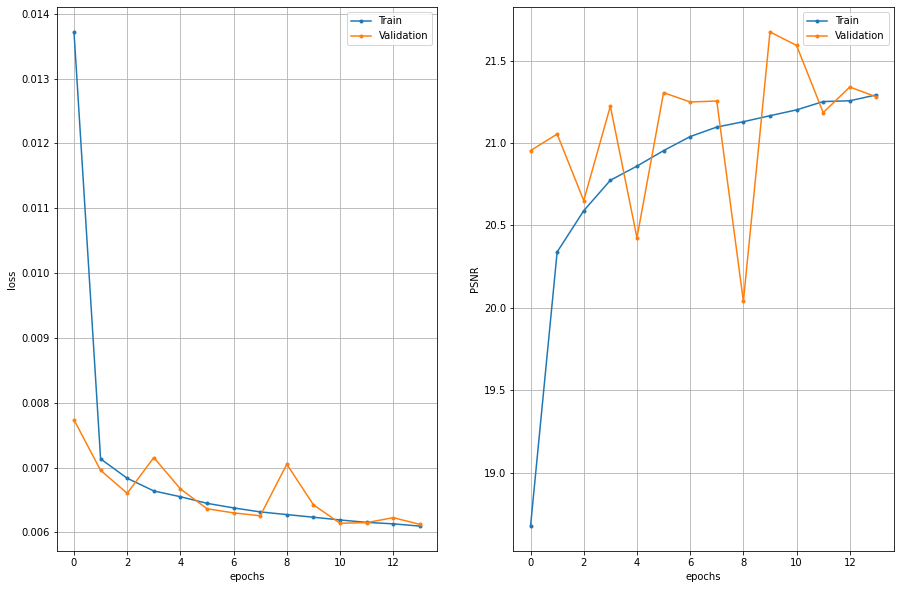

In [33]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['psnr'], '.-',
                           epochs, h['val_psnr'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('PSNR')
plt.legend(['Train', 'Validation'])

print('Train PSNR     ', h['psnr'][-1])
print('Validation PSNR', h['val_psnr'][-1])    

Predict and visualize (Input, Input upscaled by OpenCV, Predicted)

1/1 [==============================] - 2s 2s/step


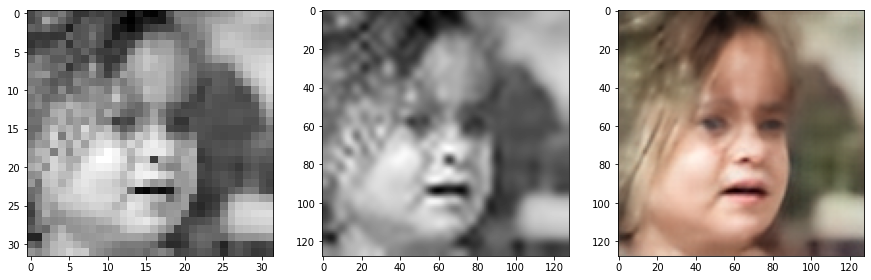

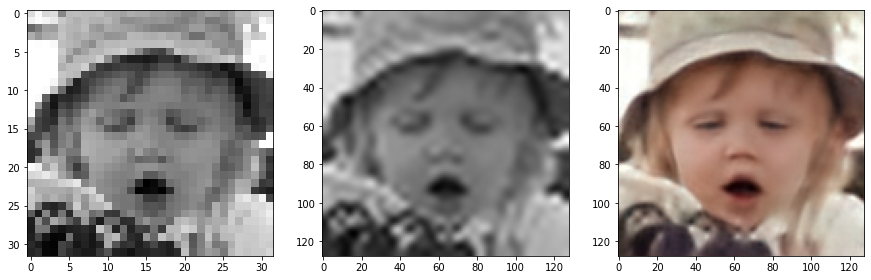

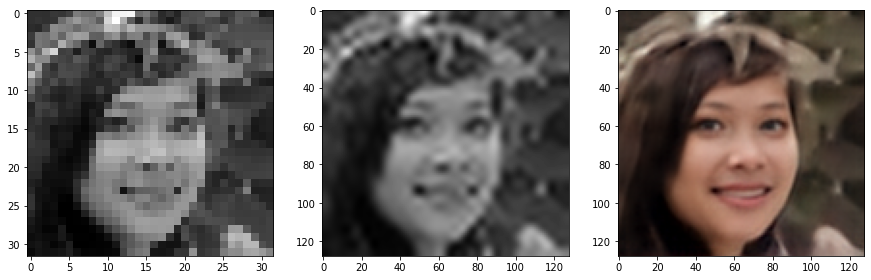

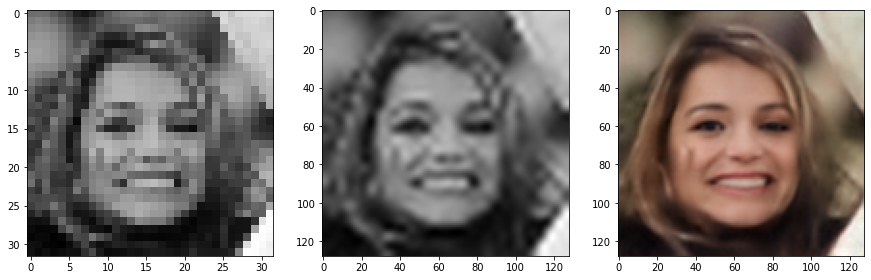

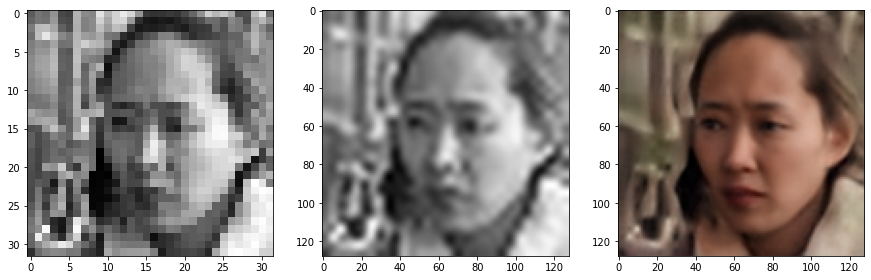

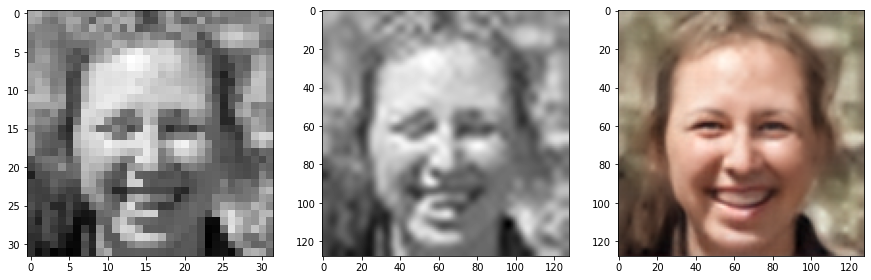

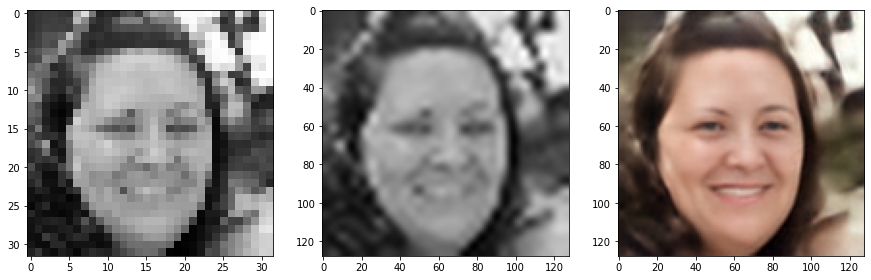

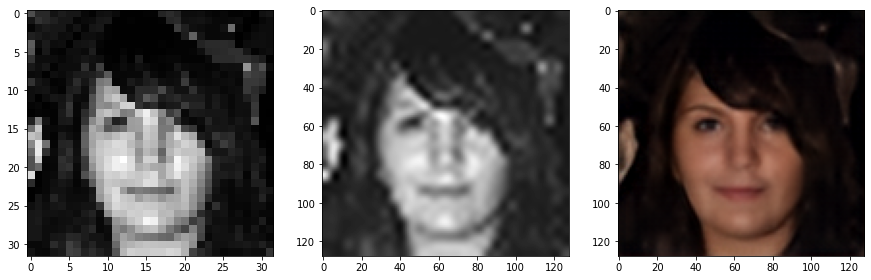

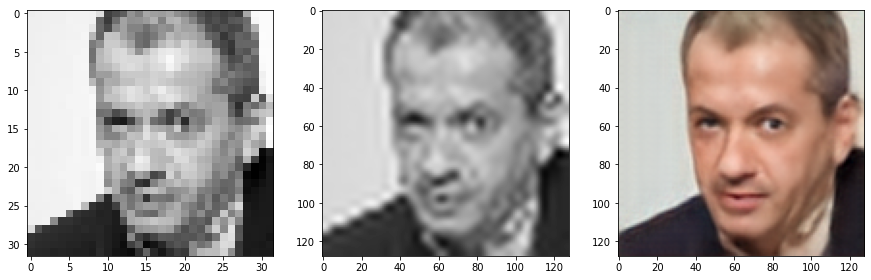

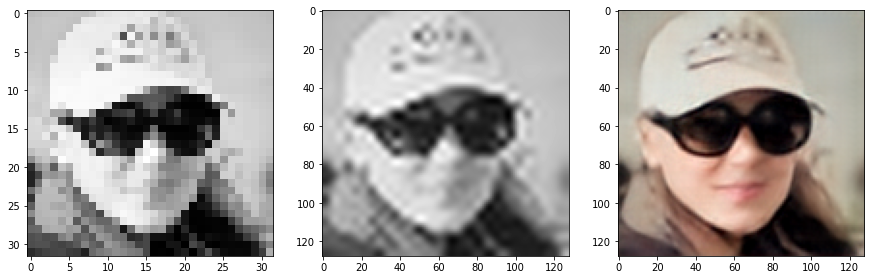

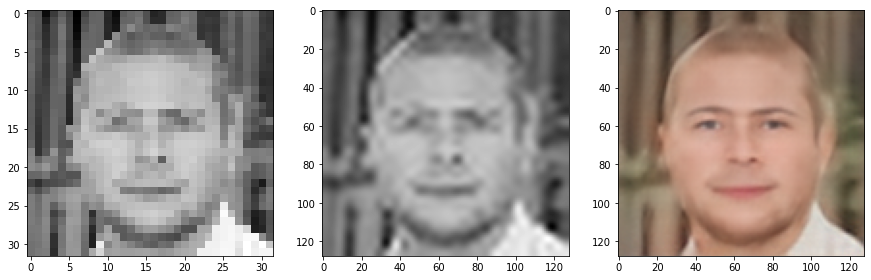

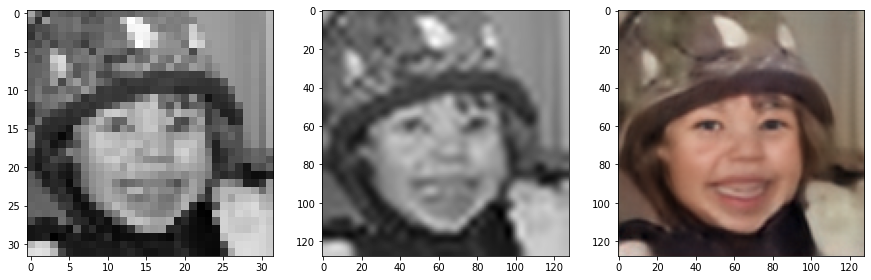

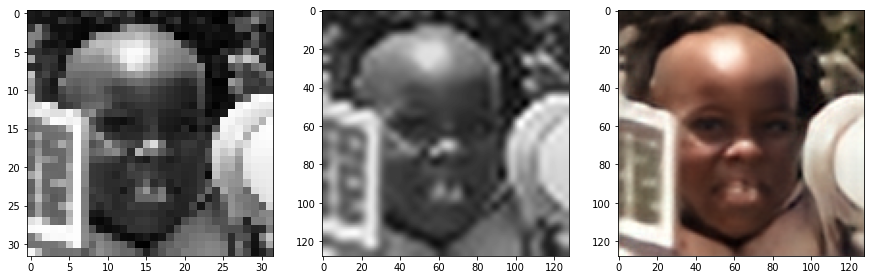

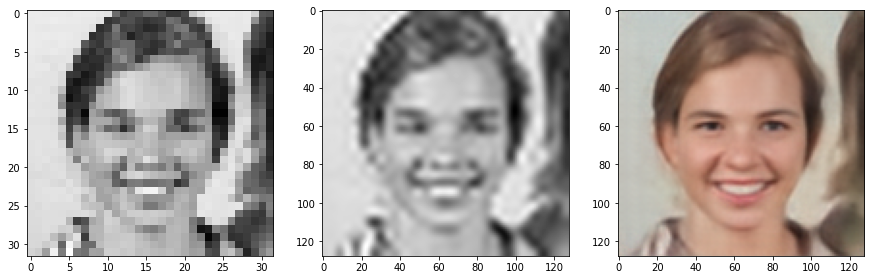

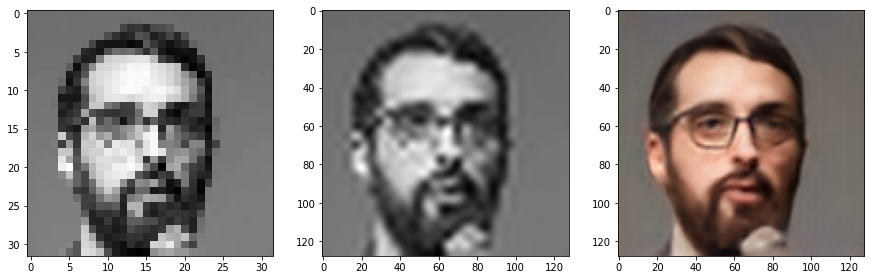

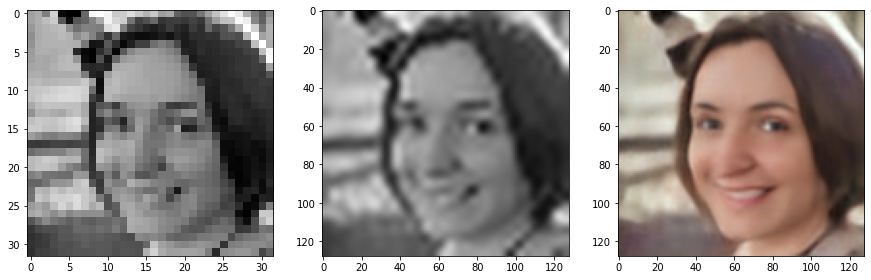

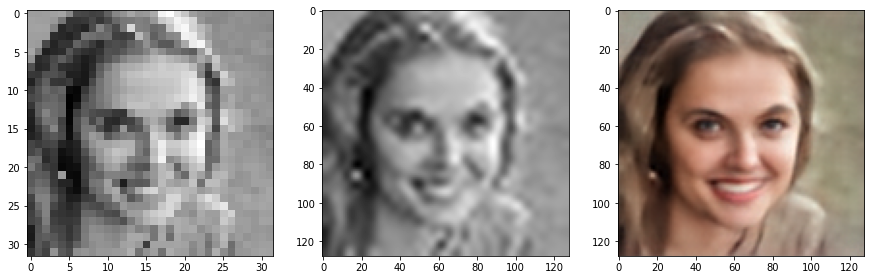

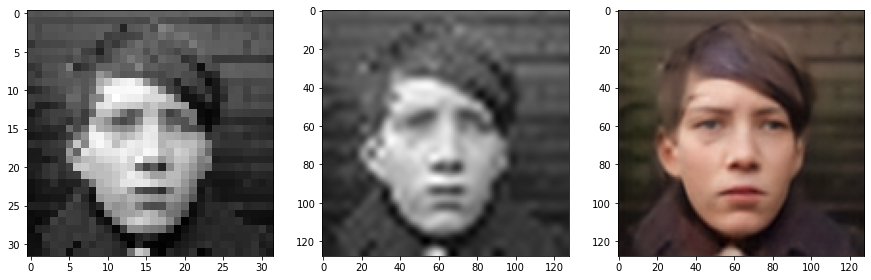

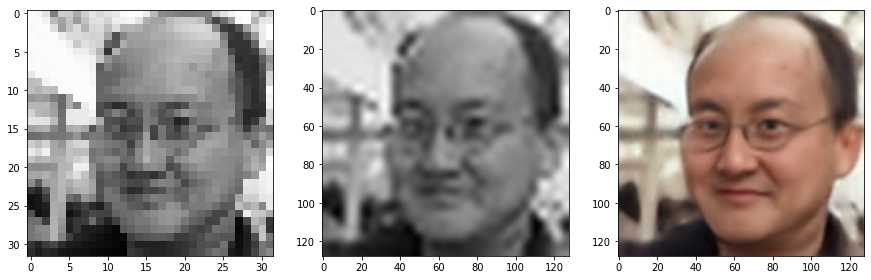

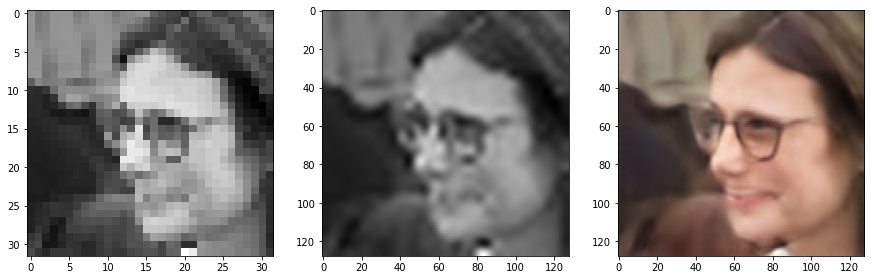

In [34]:
# prepare test images
test_range = 20
di = data_iterator(test_files_iterator(), test_range)
batch = next(di)
x_test = batch[0]

# predict
y_test = model.predict(x_test)

# visualize
for ii in range(test_range):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x_test[ii], cmap='gray')
    axarr[1].imshow(cv2.resize(x_test[ii], (y_img_size, y_img_size), interpolation=cv2.INTER_LANCZOS4), cmap='gray')
    axarr[2].imshow(np.array(y_test[ii]))


Save the model if needed

In [35]:
model.save('/content/drive/MyDrive/ColabNotebooks/FaceUpscale/model')